# Udacity Data Wrangling Project

### Importing Libraries and Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tweepy
#from tweepy import OAuthHandler
#import json
#from timeit import default_timer as timer
import re
import requests


import twitter_credentials
%matplotlib inline

# Gather

###  Gathering Get Request

In [2]:
#response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
#if response.status_code == 200:
#    print('Success!')
#elif response.status_code == 404:
#    print('Not Found.')

In [3]:
images = pd.read_csv('image_predictions.tsv', sep = '\t', encoding = 'utf-8')

### Gathering data manually with Pandas

In [4]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv')

### Gathering with the Twitter API



_With a quick assessment of the tweet_id column I saw a unique problem I would need to solve first before being able to gather my last dataset containing all of the twitter data._

In [5]:
df_1.tweet_id.head()

0    8.924210e+17
1    8.921770e+17
2    8.918150e+17
3    8.916900e+17
4    8.913280e+17
Name: tweet_id, dtype: float64

_Gathering tweets from the twitter API requires precise Tweet_id's and unfortunately my csv was imported with a column of twitter_id that had some rounding errors._

In [6]:
with pd.option_context('float_format', '{:.0f}'.format):  
    print(df_1.tweet_id.head())

0   892421000000000000
1   892177000000000000
2   891815000000000000
3   891690000000000000
4   891328000000000000
Name: tweet_id, dtype: float64


_My solution to this issue was to split the strings of the URLs addresses that were included in the twitter_enhanced_archive csv file.  Using regular expression, I would be able to extract the Tweet Id's from the end of every URL which required seperating the digits(these would be the tweet_id's I needed) from all of the char values that came before them._

In [7]:
df_1.expanded_urls.head()

0    https://twitter.com/dog_rates/status/892420643...
1    https://twitter.com/dog_rates/status/892177421...
2    https://twitter.com/dog_rates/status/891815181...
3    https://twitter.com/dog_rates/status/891689557...
4    https://twitter.com/dog_rates/status/891327558...
Name: expanded_urls, dtype: object

_My first step was to drop and null value in the expanded_urls, then take all of the remaining rows and place them into a list._

In [8]:
df_1['expanded_urls'] = df_1.expanded_urls.fillna(value='https://www.twitter.com')
urls = df_1.expanded_urls
urls = list(urls)

_Next I created a new empty list, **status**, and used a loop to extract the tweet_id's from **urls**, appending
each tweet_id to **status**. As a conditional, also appended the string '0' to status, every time my search
was unable to find an accurate tweet_id_

In [9]:
status= []
for i in range(len(urls)): 
    t= urls[i]
    if bool(re.search(r'\d', t)) == True:
        twt = re.findall(r'\d+', t)[0]
        status.append(twt)
    else:
        status.append('0')
status[:5]

['892420643555336193',
 '892177421306343426',
 '891815181378084864',
 '891689557279858688',
 '891327558926688256']

_I replaced my DataFrame column **['tweet_id']** with the values in **status** then removed all the values
that contained the string '0'._

In [10]:
df_1['tweet_id'] = status
df_1 = df_1.query("tweet_id != '0'")

_My last step was to change the data type of **['tweet_id']** from strings to the int64 data type, standardizing the **tweet_id** data type accross various sources of data to be able to merge in the future, and preparing them for my next gathering step of the Twitter API. Additionally, int64 also is the most efficient way to store values of unique digits, as integers require much less memory than a string._

In [11]:
df_1 = df_1.astype({'tweet_id':'int64'})

In [12]:
tweet_ids = df_1['tweet_id']

In [13]:
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
            
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)


In [14]:
#df_2 = pd.DataFrame(columns=['tweet_id','retweet count','favorite_count'])

#with open('tweet_json.txt') as i:
#    for line in i:
#        stat = json.loads(line)
#        tweet_id = stat['id_str']
#        retweet_count = stat['retweet_count']
#        favorite_count = stat['favorite_count']
#        df_2 = df_2.append(pd.DataFrame([[tweet_id,retweet_count,
#                                         favorite_count]], 
#                                       columns=['tweet_id',
#                                        'retweet_count', 'favorite_count']))
#df_2 = df_2.reset_index(drop=True)
#df_2.head()
        

In [15]:
#df_2.to_csv (r'C:\Users\tssan\Desktop\Udacity Projects\4wrangle\WeRateDogs.csv',
#                          index = None, header=True, sep='\t', encoding='utf-8')

In [16]:
df_2 = pd.read_csv('WeRateDogs.csv', sep='\t',encoding='utf-8')

# Assessment
### Visual Assessment

In [17]:
df_1.loc[:9].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,nan,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,nan,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,nan,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,nan,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,nan,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,nan,nan,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,nan,nan,nan,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,nan,nan,2017-07-28 16:27:12 +0000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,nan,nan,nan,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,nan,nan,2017-07-28 00:22:40 +0000,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,nan,nan,nan,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,nan,nan,2017-07-27 16:25:51 +0000,Twitter for iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,nan,nan,nan,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,nan,nan,2017-07-26 15:59:51 +0000,Twitter for iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,nan,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,None,None,None


- Five columns in the **df_1** Dataframe appear to contain missing values: 
    - **in_reply_to_status_id**, 
    - **in_reply_to_user_id**, 
    - **retweeed_status_id**, 
    - **retweeted_status_user_id**,  
    - **retweeted_status_timestamp** 
 
- The **text** column contains the body of the tweet, but then ends each tweet with a hyperlink.  The hyperlink is already represented in the **expanded_urls** column, so having it shown twice is redundant information and is not really part of the text of the tweet. 
- The columns **doggo**, **floofer**, **pupper**, and **puppo** have the string "None" in many of there rows. These columns seem to be categorical varibales and would benefit by finding a melt them into a single categorical column.
- The **timestamp** column is formatted down to the millisecond. This is accurate and thourough information, but for future timeseries analysis, I will convert the time in a date format of yyyy-MM-dd instead of the yyyy-MM-dd HH:mm:ss. SSS it is in now.

In [18]:
images.loc[:10].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.0741917,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.0161992,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.0458854,False,terrapin,0.0178853,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.0582794,True,fur_coat,0.0544486,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.0145938,False,golden_retriever,0.00795896,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.0820861,True


- The columns **p1**, **p2**, and **p3** are all in snake case format and some of the categorical values are capitalized while others are not.  To clean this up I would like to remove the underscore(s) of each row and put the classications in title format 

In [19]:
df_2.loc[:9].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,favorite_count,retweet count,retweet_count,tweet_id
0,37135,nan,7937,892420643555336193
1,31939,nan,5900,892177421306343426
2,24054,nan,3899,891815181378084864
3,40456,nan,8095,891689557279858688
4,38672,nan,8778,891327558926688256
5,19442,nan,2917,891087950875897856
6,11340,nan,1937,890971913173991426
7,62632,nan,17701,890729181411237888
8,26740,nan,4020,890609185150312448
9,30632,nan,6903,890240255349198849


**retweet count** is an inconsistent format by not having an underscore to replace the space between words. By grouping column names in snake case the column names of a dataframe are callable. This would likely be a column name that I renamed to much python convention for a column name but it looks like it is a duplicate column to **reteet_count** and has a majority of NaN values. I will drop the column **retweet count** to tidy up the **df_2** DataFrame.

### Programatic Assessment

In [20]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2270 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2270 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2270 non-null object
source                        2270 non-null object
text                          2270 non-null object
retweeted_status_id           176 non-null float64
retweeted_status_user_id      176 non-null float64
retweeted_status_timestamp    176 non-null object
expanded_urls                 2270 non-null object
rating_numerator              2270 non-null int64
rating_denominator            2270 non-null int64
name                          2270 non-null object
doggo                         2270 non-null object
floofer                       2270 non-null object
pupper                        2270 non-null object
puppo                         2270 non-null object
dtypes: float64(4), int64(3), ob

- As observed above, five columns have missing values.
    - **in_reply_to_status_id** and **in_reply_to_user_id** each have 2247 null values
    - **retweeed_status_id**, **retweeted_status_user_id**, and **retweeted_status_timestamp** each have 2094 null values

In [21]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 4 columns):
favorite_count    2166 non-null int64
retweet count     0 non-null float64
retweet_count     2166 non-null float64
tweet_id          2166 non-null int64
dtypes: float64(2), int64(2)
memory usage: 67.8 KB


- After running a summary of the dataframe **df_2** we see that all 2166 values are missing in the column **retweet count**

In [22]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- The **images** dataframe has no missing values. 

In [23]:
df_1.groupby(['rating_numerator']).count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_denominator,name,doggo,floofer,pupper,puppo
rating_numerator,,,,,,,,,,,,,,,,
0,2,1,1,2,2,2,0,0,0,2,2,2,2,2,2,2
1,6,0,0,6,6,6,1,1,1,6,6,6,6,6,6,6
2,9,0,0,9,9,9,0,0,0,9,9,9,9,9,9,9
3,19,0,0,19,19,19,0,0,0,19,19,19,19,19,19,19
4,16,0,0,16,16,16,0,0,0,16,16,16,16,16,16,16
5,35,0,0,35,35,35,1,1,1,35,35,35,35,35,35,35
6,32,0,0,32,32,32,0,0,0,32,32,32,32,32,32,32
7,53,0,0,53,53,53,1,1,1,53,53,53,53,53,53,53
8,102,0,0,102,102,102,4,4,4,102,102,102,102,102,102,102


What stood out to me the most while looking over the numerator values is that for all the numerators
greater than 14, all of the values are listed only once, with the exception of 75.
I decided to look into this a little further to figure out why this was.

In [24]:
ind1, ind2 = df_1.text[df_1.rating_numerator== 75].index.tolist()
num = 75
text1, text2 = df_1.text[ind1], df_1.text[ind2]
print(f'Index: {ind1}\nNumerator: {num}\n{text1} \n\nIndex: {ind2}\nNumerator: {num}\n{text2}')

Index: 340
Numerator: 75
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 

Index: 695
Numerator: 75
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS


Two problems were 

In [25]:
df_1.tweet_id.duplicated().any()

True

In [26]:
df_2.tweet_id.duplicated().any()

True

In [27]:
images.tweet_id.duplicated().any()

False

In [28]:
df_1.groupby(['rating_denominator']).count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
rating_denominator,,,,,,,,,,,,,,,,
2,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1
7,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1
10,2251,22,22,2251,2251,2251,175,175,175,2251,2251,2251,2251,2251,2251,2251
11,3,0,0,3,3,3,1,1,1,3,3,3,3,3,3,3
20,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1
40,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1
50,3,0,0,3,3,3,0,0,0,3,3,3,3,3,3,3
70,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1
80,2,0,0,2,2,2,0,0,0,2,2,2,2,2,2,2


In [29]:
df_1.query('rating_denominator > 10').rating_denominator.count()

17

In [30]:
df_1.query('rating_denominator < 10').rating_denominator.count()

2

2251 of the 2270 observations have a denominator of ten.  Only 2 had a denominator less than ten and 17 had denominators greater than ten.  I decided to look into this further to see if I could find out why this was.

First I checked the denominators that had values less then ten

In [31]:
ind1, ind2 = df_1.text[df_1.rating_denominator < 10].index.tolist()
denom1, denom2 = df_1.rating_denominator[ind1], df_1.rating_denominator[ind2]
text1, text2 = df_1.text[ind1], df_1.text[ind2]
print(f'Index: {ind1}\nDenominator:{denom1}\n{text1} \n\n\nIndex: {ind2} \nDenominator:{denom2}\n{text2}')

Index: 516
Denominator:7
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 


Index: 2335 
Denominator:2
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [32]:
ind = df_1.query('rating_denominator > 10')['rating_denominator'].index.tolist()
denom = df_1.query('rating_denominator > 10')['rating_denominator'].tolist()
text = df_1.query('rating_denominator > 10')['text'].tolist()
for i in range(len(ind)):
    nex_ind = ind[i]
    nex_denom = denom[i]
    nex_text = text[i]
    print(f'Index: {nex_ind}\nDenominator: {nex_denom}\n{nex_text}\n')

Index: 433
Denominator: 70
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

Index: 784
Denominator: 11
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…

Index: 902
Denominator: 150
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

Index: 1068
Denominator: 11
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

Index: 1120
Denominator: 170
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv

Index: 1165
Denominator: 20
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a

Index: 1202
Denominator: 50
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq

Index: 1228
Denominator: 90
Happ

In [33]:
testset = [] 
for i, row in df_1.iterrows():
    if df_1.rating_denominator[i] != 10:
        in_str= row['text']
        try:
            test = re.search(r'\d+(?:\.\d+)?/10', in_str).group()
            test = re.findall(r'\d+', test)[0]
            df_1.at[i,'rating_numerator'] = test
        except:
            test = 'Unchanged'
        if test == 'Unchanged':
            denominator = 'Unchanged'
        else:
            denominator = '10'
                
        print(f'Index: {i}\nNumerator: {test}\nDenominator: {denominator}\n{in_str}\n')
        testset.append(test)
    else:
        pass

Index: 433
Numerator: Unchanged
Denominator: Unchanged
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

Index: 516
Numerator: Unchanged
Denominator: Unchanged
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx

Index: 784
Numerator: 14
Denominator: 10
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…

Index: 902
Numerator: Unchanged
Denominator: Unchanged
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

Index: 1068
Numerator: 14
Denominator: 10
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

Index: 1120
Numerator: Unchanged
Denominator: Unchanged
Say hello to this unbelievably well behaved squad of doggos. 2

In [34]:
df_1['timestamp'].min(), df_1['timestamp'].max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

In [35]:
df_1.timestamp[:5]

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

### Summary of Assessment

#### Quality issues
**df_1** dataset
- stuff
- stuff
- stuff
- stuff
- stuff

**df_2** dataset
- stuff
- stuff
- stuff

**images** dataset
- No quality errors were found in this dataset


#### Tidiness Issues
**df_1** dataset 
- stuff
- stuff
- stuff

**df_2** dataset
- stuff
- stuff
- stuff

**images** dataset
- stuff
- stuff



# Clean

In [36]:
df_1_clean = df_1.copy()
df_2_clean = df_2.copy()
images_clean = images.copy()

### Missing Data

##### Define
- 1. Dropping the columns with a majority of NaN values from the **df_1** dataframe

##### Code

In [37]:
df_1.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                   'retweeted_status_user_id','retweeted_status_timestamp'
                   ], inplace=True)

##### Test the results

In [38]:
df_1.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

##### Define
- 2. Melting Doggo, Pupper, Floofer, and Puppo down to one category variable named Cute_Name in the **df_1** Dataframe  

#####  Code

In [39]:
a = df_1['doggo']
b = df_1['pupper']
c = df_1['floofer']
d = df_1['puppo']


df_1['cute_name'] = a.str.cat(b.replace('None','')).str.cat(c.replace('None','')).str.cat(d.replace('None',''))

In [40]:
dict_dog = {'Nonefloofer':'floofer','Nonepupper':'pupper','Nonepuppo':'puppo','doggopupper':'doggo, pupper',
           'doggofloofer':'doggo, floofer','doggopuppo':'doggo, puppo','None':'Other'}

for key, value in dict_dog.items():
    df_1['cute_name'] = df_1.cute_name.replace(key,value)
    
df_1.drop(columns=['doggo', 'floofer','pupper', 'puppo'],inplace=True)

##### Test the results

In [41]:
df_1.cute_name.value_counts()

Other             1898
pupper             241
doggo               80
puppo               28
doggo, pupper       12
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: cute_name, dtype: int64

In [42]:
df_1.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'cute_name'],
      dtype='object')

##### Define
- 3. 

#####  Code

##### Test the results

In [43]:
print(f"This dog's rating is {df_1.loc[2335,'rating_numerator']}/{df_1.loc[2335,'rating_denominator']}")

This dog's rating is 9/2


##### Define
- 4. Fixing Tweet 516 (No rating given) in the **df_1** Dataframe

#####  Code

In [44]:
df_1.loc[516, 'rating_numerator']= np.median(df_1.rating_numerator)
df_1.loc[516, 'rating_denominator']= np.median(df_1.rating_denominator)

_4. Test the results_

In [45]:
print(f"Since Sam was never given a rating, I gave him the median rating which is {df_1.loc[516,'rating_numerator']}/{df_1.loc[516,'rating_denominator']}")

Since Sam was never given a rating, I gave him the median rating which is 11.0/10.0


##### Define
- 5. Dropping the duplicate in the **df_1** and **df_2** Dataframes

#####  Code

In [46]:
df_1 = df_1.drop_duplicates(subset=['tweet_id'],keep='first')
df_2 = df_2.drop_duplicates(subset=['tweet_id'],keep='first')

##### Test the results

In [47]:
df_1.tweet_id.duplicated().any(), df_2.tweet_id.duplicated().any()

(False, False)

##### Define
- 6. Dropping columns with null data in the **df_2** Dataframe

#####  Code

In [48]:
df_2.drop(columns='retweet count', inplace= True)

##### Test the results

In [49]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2026 entries, 0 to 2165
Data columns (total 3 columns):
favorite_count    2026 non-null int64
retweet_count     2026 non-null float64
tweet_id          2026 non-null int64
dtypes: float64(1), int64(2)
memory usage: 63.3 KB


##### Define
- 7. Merging **df_1**, **df_2**, and **images** Dataframes into a single table

#####  Code

In [50]:
df = df_1.merge(df_2, on='tweet_id', how='inner')

In [51]:
df = df.merge(images, on='tweet_id', how='inner')
df = df.reset_index(drop=True)

##### Test the results

In [52]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,cute_name,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,Other,37135,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,Other,31939,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,Other,24054,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,Other,40456,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,Other,38672,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 22 columns):
tweet_id              1979 non-null int64
timestamp             1979 non-null object
source                1979 non-null object
text                  1979 non-null object
expanded_urls         1979 non-null object
rating_numerator      1979 non-null float64
rating_denominator    1979 non-null float64
name                  1979 non-null object
cute_name             1979 non-null object
favorite_count        1979 non-null int64
retweet_count         1979 non-null float64
jpg_url               1979 non-null object
img_num               1979 non-null int64
p1                    1979 non-null object
p1_conf               1979 non-null float64
p1_dog                1979 non-null bool
p2                    1979 non-null object
p2_conf               1979 non-null float64
p2_dog                1979 non-null bool
p3                    1979 non-null object
p3_conf               1979 non-null

##### Define
- 8. Dropping the 'source' column from **df** table

#####  Code

In [54]:
df.drop(columns=['source'],inplace=True)

##### Test the results

In [55]:
df.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'cute_name', 'favorite_count',
       'retweet_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

##### Define
- 9. Normalizing Denominators to a Standard of 10 structuring data to facilitate analysis **df**

#####  Code

In [56]:
norm_numerator= []
norm_denominator= []
for i, row in df.iterrows():
    norm = 10 / row['rating_denominator']
    num = row['rating_numerator'] = row['rating_numerator']* norm
    norm_numerator.append(num)
    den = row['rating_denominator'] = row['rating_denominator']* norm
    norm_denominator.append(den)
    

In [57]:
df['rating_numerator'] = norm_numerator
df['rating_denominator'] = norm_denominator

##### Test the results

In [58]:
df.query('rating_denominator !=10')['rating_denominator'].any()

False

In [59]:
df.drop(columns=['rating_denominator'],inplace = True)
df.rename(columns={"rating_numerator": "rating"},inplace=True)

In [60]:
df.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating', 'name',
       'cute_name', 'favorite_count', 'retweet_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

In [61]:
df.rating.value_counts()

12.000000      449
10.000000      419
11.000000      401
13.000000      254
9.000000       151
8.000000        95
7.000000        51
14.000000       35
5.000000        33
6.000000        32
3.000000        19
4.000000        15
2.000000         9
1.000000         4
0.000000         2
9.090909         1
2.200000         1
6.500000         1
26.000000        1
45.000000        1
12.727273        1
75.000000        1
1776.000000      1
420.000000       1
27.000000        1
Name: rating, dtype: int64

##### Define
- 12.  Correcting Ratings Containing Decimal Places, Using Regular Expression to loop through each text and pull out any digits with decimal places in **df**

#####  Code

In [62]:
for i, row in df.iterrows():
    in_str= row['text']
    split = re.split(r'/' , in_str)[0]
    if bool(re.search(r'\d+\.\d+$', split)) == True:
        after = re.findall(r'\d+\.\d+', split)[0]
        before = df.loc[i, 'rating']
        df.loc[i, 'rating'] = after
        print(f"The rating in row {i} used to be {before} and now is {after}.")
    else:
        pass

The rating in row 40 used to be 5.0 and now is 13.5.
The rating in row 262 used to be 75.0 and now is 9.75.
The rating in row 585 used to be 27.0 and now is 11.27.
The rating in row 1380 used to be 26.0 and now is 11.26.


In [63]:
df.rating.dtype

dtype('O')

In [64]:
#No longer need the denominator columns, and the rating_numerator column
#can just become rating (on a standardized scale of 10)
df['rating'] = df['rating'].astype('float64')


##### Test the results

##### Define
- 13. 

#####  Code

In [65]:
# Rounding Ratings to get a discrete scale
for i, row in df.iterrows():
    before = df.loc[i, 'rating']
    after = round(df.rating[i], 0)
    df.loc[i, 'rating'] = after
    if bool(before == after) == False :
        print(f"The rating in row {i} used to be {before} and now is {after}.")
    else:
        pass

The rating in row 40 used to be 13.5 and now is 14.0.
The rating in row 262 used to be 9.75 and now is 10.0.
The rating in row 585 used to be 11.27 and now is 11.0.
The rating in row 602 used to be 12.727272727272727 and now is 13.0.
The rating in row 915 used to be 6.5 and now is 6.0.
The rating in row 948 used to be 2.2 and now is 2.0.
The rating in row 1336 used to be 9.09090909090909 and now is 9.0.
The rating in row 1380 used to be 11.26 and now is 11.0.


##### Define
- 14. 


#####  Code

In [66]:
df['text'] = df.text.apply(lambda text: text.split('http')[0])

##### Test the results

In [67]:
line1 = df.text[np.random.randint(0,2000)]
line2 = df.text[np.random.randint(0,2000)]
line3 = df.text[np.random.randint(0,2000)]

print(f'{line1}\n\n{line2} \n\n{line3}');

This is Bode. He's a heavy sleeper. 9/10 

Yea I can't handle this job anymore your dogs are too adorable. 12/10  

This is Callie. She'll be your navigator today. Takes her job very seriously. Will shift for you. One ear always in the pupholder. 12/10 


##### Define
- 15. 

#####  Code

In [68]:
time = df['timestamp']
time = list(time)

In [69]:
times = []
for i in range(len(time)): 
    t= time[i]
    t = t.rpartition(' ')[0]
    stamp = t.rpartition(' ')[0]
    times.append(stamp)

In [70]:
df['timestamp'] = times
df['timestamp'] = pd.to_datetime(df['timestamp'])

##### Test the results

In [71]:
df.timestamp[:5]

0   2017-08-01
1   2017-08-01
2   2017-07-31
3   2017-07-30
4   2017-07-29
Name: timestamp, dtype: datetime64[ns]

##### Define
- 16. 

#####  Code

In [72]:
df = df.astype({'rating' : int, 'retweet_count' : int} )

##### Test the results

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 20 columns):
tweet_id          1979 non-null int64
timestamp         1979 non-null datetime64[ns]
text              1979 non-null object
expanded_urls     1979 non-null object
rating            1979 non-null int32
name              1979 non-null object
cute_name         1979 non-null object
favorite_count    1979 non-null int64
retweet_count     1979 non-null int32
jpg_url           1979 non-null object
img_num           1979 non-null int64
p1                1979 non-null object
p1_conf           1979 non-null float64
p1_dog            1979 non-null bool
p2                1979 non-null object
p2_conf           1979 non-null float64
p2_dog            1979 non-null bool
p3                1979 non-null object
p3_conf           1979 non-null float64
p3_dog            1979 non-null bool
dtypes: bool(3), datetime64[ns](1), float64(3), int32(2), int64(3), object(8)
memory usage: 253.3+ KB


In [74]:
#df.to_csv (r'~/Desktop/Udacity Projects/4wrangle/WeRateDogs_Clean.csv',
                        #index = False, header=True, sep='\t', encoding='utf-8')

In [75]:
df_cln = df.copy()

In [76]:
#df_cln = pd.read_csv('WeRateDogs_Clean.csv', sep='\t',encoding='utf-8')

# Finding a Winner

In [77]:
df_cln.groupby(['rating']).count()

,tweet_id,timestamp,text,expanded_urls,name,cute_name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating,,,,,,,,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
3,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
4,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
7,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
8,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95


In [78]:
df_cln[df_cln['rating'] == 420]

,tweet_id,timestamp,text,expanded_urls,rating,name,cute_name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1712,670842764863651840,2015-11-29,After so many requests... here you go.\r\n\r\n...,https://twitter.com/dog_rates/status/670842764...,420,None,Other,24351,8574,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False


In [79]:
df_cln.text[1712]

'After so many requests... here you go.\r\n\r\nGood dogg. 420/10 '

In [80]:
print(df_cln.jpg_url[1712])

https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg


### At second place Snoop Dogg comes in at very impressive 420 out of 10
<img src="second.jpg"/>

In [81]:
df_cln[df_cln['rating'] == 1776]

,tweet_id,timestamp,text,expanded_urls,rating,name,cute_name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
757,749981277374128128,2016-07-04,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,Atticus,Other,5253,2528,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False


In [82]:
df_cln.text[757]

"This is Atticus. He's quite simply America af. 1776/10 "

In [83]:
print(df_cln.jpg_url[757])

https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg


### Congratulation to the winner coming in at 1776 out of 10, such a good boy!
<img src="winner.jpg"/>

## Distribution of Dog Ratings by Dog Types

_The two winners above are data points that were accurately gathered, but their ratings are also global outliers to the rest of the observations. But as we can see from the box plots below, these global outliers greatly increase the standard deviation of the variable **rating** in our DataFrame.  
To facilitate easier analysis, I decided to remove the two outliers, and take a deeper look into the distribution of ratings by dog type._

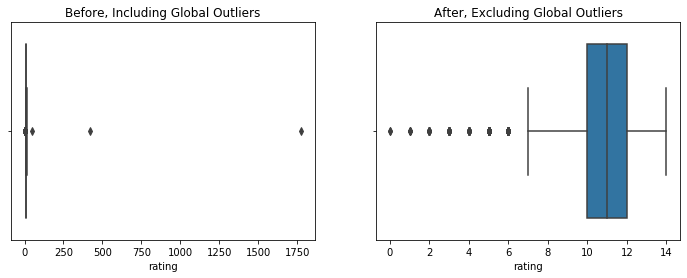

In [84]:
df_before= df_cln.copy()
df_after = df_cln[df_cln['rating'] < 15]

#df_before= plots of the distribution of the data before and after removing the two outliers
f, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_before,x= 'rating',orient='w', ax=axes[0])
axes[0].set_title('Before, Including Global Outliers')


sns.boxplot(data=df_after, x= 'rating',orient='w', ax=axes[1])
axes[1].set_title('After, Excluding Global Outliers');

In [85]:
df_rate = df_after.copy()

In [86]:
df_rate['p1'].value_counts()

golden_retriever      138
Labrador_retriever     92
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
crash_helmet            1
bighorn                 1
platypus                1
EntleBucher             1
banana                  1
Name: p1, Length: 372, dtype: int64

In [87]:
dog_types = df_rate['p1'].value_counts().keys()
dog_types = list(dog_types)

In [88]:
dog_types = dog_types[:9]

In [89]:
for d in dog_types:
    df_other = df_rate[(df_rate.p1 != d)]

df_other = df_other.rating.value_counts().sort_index()
df_other = df_other.rename_axis('rating').to_frame('other')

for d in dog_types:
    df_add = df_rate[df_rate['p1'] == d ]
    df_add = df_add.rating.value_counts().sort_index()
    df_add = df_add.rename_axis('rating').to_frame(d)
    df_other = df_other.merge(df_add, on='rating',how='left').fillna(0)
    

df_other.loc[:,'Total'] = df_other.sum(axis=1)
df_other.index = df_other.index.map(str)
df_other.columns = [x.lower() for x in df_other.columns]
df_all = df_other.copy()
df_all

,other,golden_retriever,labrador_retriever,pembroke,chihuahua,pug,chow,samoyed,pomeranian,toy_poodle,total
rating,,,,,,,,,,,
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,19,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,21.0
4,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
5,32,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,34.0
6,33,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,35.0
7,51,0.0,1.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,60.0
8,95,2.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,106.0


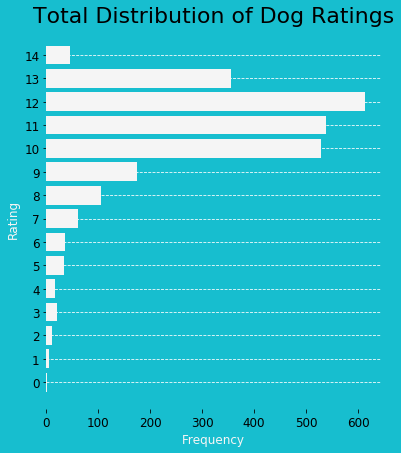

In [90]:
b='Black'
r = df_all.index
t = df_all.total
c= sns.color_palette()[9]
f_sz=12
w='whitesmoke'
fig = plt.figure(figsize=(6,7), facecolor=c)

            
ax = plt.subplot(1, 1, 1)
plt.barh(range(len(r)),t, color=w)
plt.yticks(range(len(r)),r,fontsize=12, color=b)
plt.ylabel('Rating',color=w,fontsize=f_sz)
plt.xticks(color=b,fontsize=f_sz)
plt.xlabel('Frequency',color=w,fontsize=f_sz)
plt.title('Total Distribution of Dog Ratings',color='Black',fontsize=22)

ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='dashed')
plt.box(False)
plt.show()

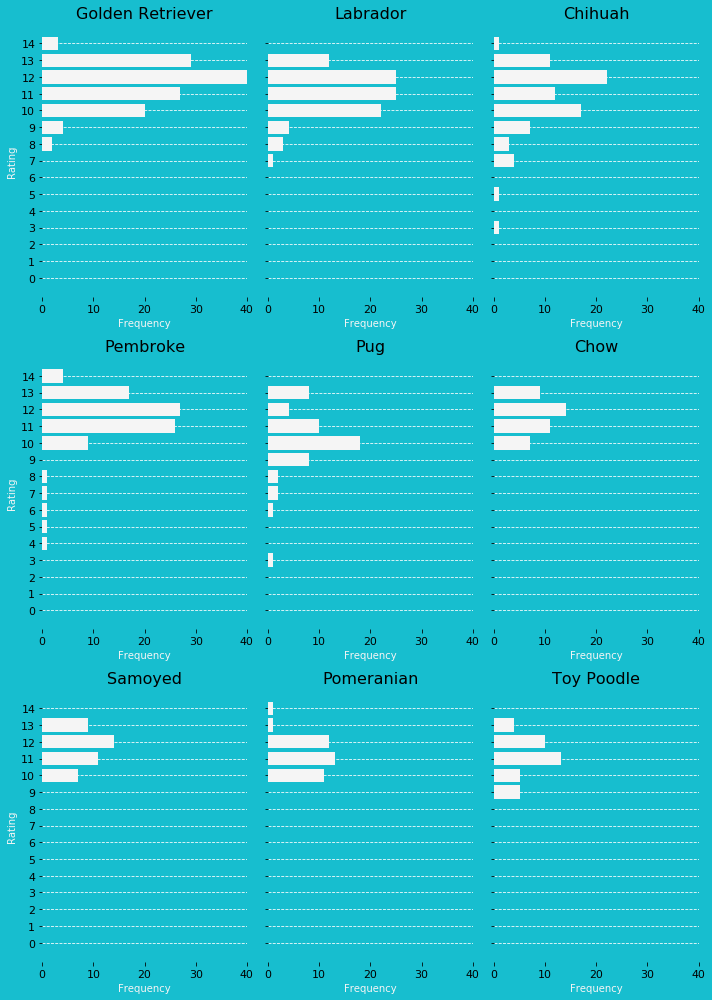

In [91]:
from mpl_toolkits.axes_grid1 import Grid
i = df_all.index
t = df_all.total
r = df_all.index
ch = df_all.chihuahua
g = df_all.golden_retriever
l = df_all.labrador_retriever
p = df_all.pembroke
pu = df_all.pug
ow = df_all.chow
s = df_all.samoyed
pm = df_all.pomeranian
tp = df_all.toy_poodle
c= sns.color_palette()[9]
w='whitesmoke'
b='Black'
f_sz=16
lim = [0,40]
fig = plt.figure(figsize=(10,14), facecolor=c)
grid = Grid(fig, rect=111, nrows_ncols=(2,2),
            axes_pad=0.25, label_mode='L')



ax1= plt.subplot(3, 3, 1)
plt.barh(range(len(r)),g, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b,fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Golden Retriever',fontsize=f_sz,color=b)
plt.xlim(lim)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='white', linestyle='dashed')

ax2= plt.subplot(3, 3, 2)
plt.barh(range(len(r)),l, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Labrador',fontsize=f_sz,color=b)
plt.xlim(lim)
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='white', linestyle='dashed')

ax3 = plt.subplot(3, 3, 3)
plt.barh(range(len(r)),ch, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chihuah',fontsize=f_sz,color=b)
plt.xlim(lim)
ax3.set_axisbelow(True)
ax3.yaxis.grid(color='white', linestyle='dashed')

ax4 = plt.subplot(3, 3, 4)
plt.barh(range(len(r)),p, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Pembroke',fontsize=f_sz,color=b)
plt.xlim(lim)
ax4.set_axisbelow(True)
ax4.yaxis.grid(color='white', linestyle='dashed')

ax5 = plt.subplot(3, 3, 5)
plt.barh(range(len(r)),pu, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pug', fontsize=f_sz, color=b)
plt.xlim(lim)
ax5.set_axisbelow(True)
ax5.yaxis.grid(color='white', linestyle='dashed')

ax6 = plt.subplot(3, 3, 6)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chow', fontsize=f_sz, color=b)
plt.xlim(lim)
ax6.set_axisbelow(True)
ax6.yaxis.grid(color='white', linestyle='dashed')

ax7 = plt.subplot(3, 3, 7)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.setp(ax7.get_yticklabels(), visible=True)
plt.box(False)
plt.title('Samoyed', fontsize=f_sz, color=b)
plt.xlim(lim)
ax7.set_axisbelow(True)
ax7.yaxis.grid(color='white', linestyle='dashed')

ax8 = plt.subplot(3, 3, 8)
plt.barh(range(len(r)),pm, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax8.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pomeranian', fontsize=f_sz, color=b)
plt.xlim(lim)
ax8.set_axisbelow(True)
ax8.yaxis.grid(color='white', linestyle='dashed')

ax9 = plt.subplot(3, 3, 9)
plt.barh(range(len(r)),tp, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Toy Poodle', fontsize=f_sz, color=b)
plt.xlim(lim)
ax9.set_axisbelow(True)
ax9.yaxis.grid(color='white', linestyle='dashed')

plt.tight_layout()
plt.show()

## Time Series of WeRateDogs Tweets

In [92]:
df_time = df_cln.copy()

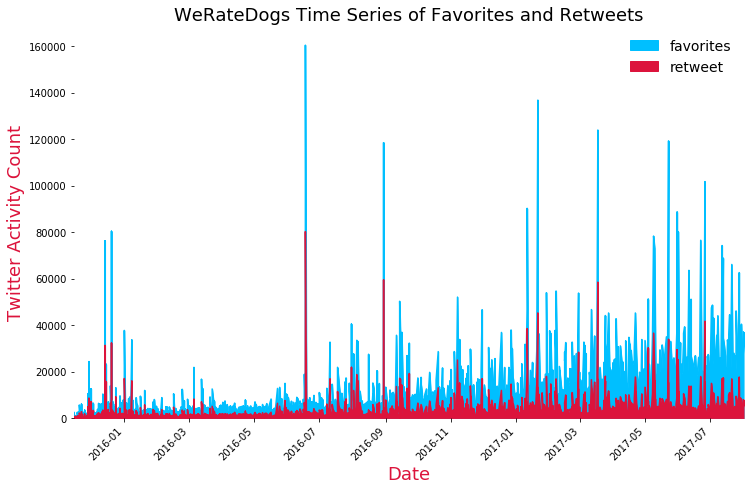

In [93]:
# TimeSeries of Twitter Activity 

#Favorite and Retweet series
time_faves = pd.Series(data=df_time['favorite_count'].values, index=df_time['timestamp']).sort_index(ascending=True)
time_retweets = pd.Series(data=df_time['retweet_count'].values, index=df_time['timestamp']).sort_index(ascending=True)

#Plotting both series to the same axis
size= (12,8)

time_faves.plot(kind='area',figsize=size, label='favorites',
                color='deepskyblue',legend=True)
time_retweets.plot(kind='area',figsize=size, label='retweet',
                   color='crimson',legend=True)

#Labels and preferences for the visualization

plt.title('WeRateDogs Time Series of Favorites and Retweets',fontsize=18)
plt.xlabel('Date',fontsize=18,color='crimson') 
plt.ylabel('Twitter Activity Count',fontsize=18, color='crimson')
plt.xticks(rotation=45)
plt.legend(fontsize=14,frameon=False)


plt.box(False)
plt.show();